# `RATstart` options


This section explores the input options for `librat`. 

Recall that we can access them in. e.g.:

In [1]:
import os
import sys
path = os.environ['PATH'].split(':')
path.extend(sys.path)
sys.path = path
BPMS=os.environ['BPMS']

In [2]:
%%bash 
source ~/.bpms_profile
# a simple object file
# and invalid code: 1000 
# to see the options
# a very simple object file
cat <<EOF > tmp.$$.obj
!{
usemtl WHITE
v 0 0 0 
sph -1 100
!}
EOF
#export LD_LIBRARY_PATH="${BPMS}/src:${LD_LIBRARY_PATH}"
#export DYLD_LIBRARY_PATH="/Users/plewis/Documents/GitHub/librat/lib:/Users/plewis/Documents/GitHub/librat/lib/x86_64:"
RATstart tmp.$$.obj <<< 1000; 

# tidy up, removing file 
rm -f $BPMSROOT/tmp.$$.obj

options:
	 0                   : quit
	 1 n s1x s1y s1z ... : set sun vectors
	 2                   : print sun vectors
	 6 fx fy fz dx dy dz : trace ray from f in direction d
	 7                   : get and print materials
	 9                   : print info on materials used
	 10                  : get and set verbosity level (0-1)
	 11                  : get and print object bbox information
	 13                  : same as 14 assuming filenames camera.dat light.dat
	 14 camera.dat light.dat
	                     : ray tracing using defined camera & illumination
	 16 cx cy cz sx sy nrows ncols rpp name
	                     : produce a height map in name


### Option 1: set sun vectors

    1 n s1x s1y s1z ... : set sun vectors
    
We will set a single sun vector, in direction `(0, 0, 0)`, so the command is:

    1 1 0 0 1

In [3]:
%%bash
source examples_init.sh
# option 0
RATstart first.obj << EOF
1 1 0 0 1
EOF

how many sun vectors? (>0): enter sun vector number 1 (3 floats): 

### Option 2: print sun vectors

	 2                   : print sun vectors
     
Now we will describe 2 suns (2 direct illumination sources), the first in direction `(0, 0, 1)` and the second in direction `(0, 1, 1)`. The input for that is:

    1 2 0 0 1 0 1 1
    
We then print the sun vectors, noticing that the outputs are normalised (unit direction vectors).

In [4]:
%%bash
source examples_init.sh
# option 0
RATstart first.obj << EOF
1 2 0 0 1 0 1 1
2
EOF


Sun vector 1: 0.000000 0.000000 1.000000
Sun vector 2: 0.000000 0.707107 0.707107


how many sun vectors? (>0): enter sun vector number 1 (3 floats): enter sun vector number 2 (3 floats): 

We could use option `2` to check what the default sun vector is:

In [5]:
%%bash
source examples_init.sh
# option 0
RATstart first.obj << EOF
2
EOF


Sun vector 1: 0.000000 0.000000 1.000000


### Option 6: trace ray from f in direction d

        6 fx fy fz dx dy dz : trace ray from f in direction d
        
Option `6` is a useful generic interface that allows us to probe intersections with the world object by sending a sample ray from some given location `(fx, fy, fz)`, in a particular direction `(dx, dy, dz)`. We return information on what the ray interacts with, tracing sample direct and diffuse rays, to a maximum ray tree depth set by the command line option `-RATm N`. Normally, we should set `N` to a high number (e.g. 1000 or higher). The command line option `-RATtolerance 0.0000000001` sets a tolerance for ray intersections, and should be appropriate to the scale of the world scene. It should be a small number, relative to typical object sizes.

In this example, we fire a ray from `(0, 0, 50)` in the direction `(0, 0, -1)` (straight down) into the scene `HET01_DIS_ERE.obj` (one of the RAMI test scenes). 

In [6]:
%%bash
source examples_init.sh

# option 6
# store the result in the file $BPMSROOT/tmp.dat
RATstart -RATr 1 \
         -RATsensor_wavebands wavebands.dat \
         -RATtolerance 0.00000000001 \
         -RATm 1000 \
         HET01_DIS_ERE.obj << EOF > $BPMSROOT/RATstart.out.dat
11
6 0 0 50 0 0 -1
EOF

# filter some information out of the object file
# for visualisation
# 1. $BPMSROOT/tmp.obj.dat
#    locations of clone objects
awk '($1=="clone"){print $2,$3,$4}' \
     < $BPMSROOT/HET01_DIS_ERE.obj \
     > $BPMSROOT/RATstart.obj.dat
     
# 2. $BPMSROOT/tmp.int.dat
#   filter ray intersections from file
#   $BPMSROOT/tmp.dat
#   Add the simulation interactions
#   add Nan to indicate new primary ray
awk '($4 == "point:"){print $5,$6,$7} \
     ($1 == "RTD"){print "Nan Nan Nan"}' \
     < $BPMSROOT/RATstart.out.dat  \
     > $BPMSROOT/RATstart.ray.dat

# output the file
cat $BPMSROOT/RATstart.out.dat 


x: -55.000000 55.000000
y: -55.000000 55.000000
z: 0.000000 27.603159
bbox centre @ 0.000000 0.000000 13.801580
RTD 7
order: 0	intersection point:	0.000000 0.000000 15.236980
		ray length:		34.763020
		intersection material:	4
		sun 0:			1 reflectance
		direct:			0.030690 0.044679 0.035031 
order: 1	intersection point:	6.619449 0.706027 12.014983
		ray length:		7.395731
		intersection material:	4
		sun 0:			no hit
order: 2	intersection point:	5.071890 2.477829 12.129398
		ray length:		2.355273
		intersection material:	4
		sun 0:			no hit
order: 3	intersection point:	11.275475 6.108373 12.234697
		ray length:		7.188630
		intersection material:	4
		sun 0:			no hit
order: 4	intersection point:	15.387118 9.326915 17.858867
		ray length:		7.674367
		intersection material:	4
		sun 0:			1 transmittance
		direct:			0.000000 0.000058 0.000000 
order: 5	intersection point:	32.539459 20.968006 17.190871
		ray length:		20.740396
		intersection material:	4
		sun 0:			1 reflectance
		direct:			0.00

We see a number of orders of interaction orders in the ray tracing. We can visualise this:

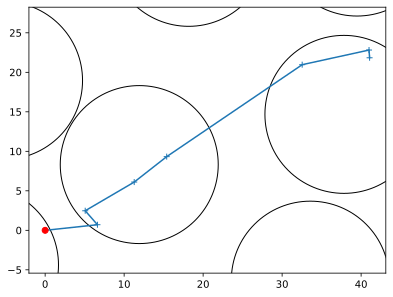

In [7]:
from RATlibUtils.plotters import plotter6
# these are the data files
# interactions
file=BPMS+"/obj/RATstart.ray.dat"
# object locations
file1=BPMS+"/obj/RATstart.obj.dat"
plotter6(file,file1)

In [8]:
%%bash
source examples_init.sh

# tidy up the files we created
rm -f $BPMSROOT/RATstart.obj.dat \
      $BPMSROOT/RATstart.out.dat \
      $BPMSROOT/RATstart.ray.dat

We can relate the path of the ray in the x-y plane (the red line, starting at the red circle) to the information on ray intersections above.

For example, looking at `intersection material` we see that most intersections are with material `4` -- this is the Leaf material, within the spheres, and others are material `3`, the soil material. Looking at the figure above, we can see that the first intersection (at `-0.000000 -0.000000 15.236980`) is on a sphere, so material 4. The next interaction is with the ground (so material 3). Then the ray path enters another sphere, bounces around within that for several interactions, then escapes, passes through the space of another sphere without interaction, then hits the ground and finally escapes.

This sort of visualisation is useful in learning how the ray tracing works.

    EXERCISE
    
    1. Use the bash script above to generate paths for 5 (or more!) primary rays.
    
    2. Visualise the paths, using the python script above (no change needed).
    
    3. Vary the integer after the -RATr flag to use a different random number seed. What is the effect?
    
**Answers below**

In [9]:
%%bash
source examples_init.sh

# option 6
# store the result in the file $BPMSROOT/tmp.dat
# just repeat the primary ray call to fire a new ray
RATstart -RATr 100 \
         -RATsensor_wavebands wavebands.dat \
         -RATtolerance 0.00000000001 \
         -RATm 1000 \
         HET01_DIS_ERE.obj << EOF > $BPMSROOT/RATstart.out.dat
6 0 0 50 0 0 -1
6 0 0 50 0 0 -1
6 0 0 50 0 0 -1
6 0 0 50 0 0 -1
6 0 0 50 0 0 -1
EOF

# filter some information out of the object file
# for visualisation
# 1. $BPMSROOT/tmp.obj.dat
#    locations of clone objects
awk < $BPMSROOT/HET01_DIS_ERE.obj \
    '($1=="clone"){print $2,$3,$4}' > $BPMSROOT/RATstart.obj.dat
# 2. $BPMSROOT/tmp.int.dat
#   filter ray intersections from file
#   $BPMSROOT/tmp.dat
#   Add the simulation interactions
#   encode Nan to separate the primary rays
awk '($4 == "point:"){print $5,$6,$7} \
     ($1 == "RTD"){print "Nan Nan Nan"}' \
     < $BPMSROOT/RATstart.out.dat  \
     > $BPMSROOT/RATstart.ray.dat

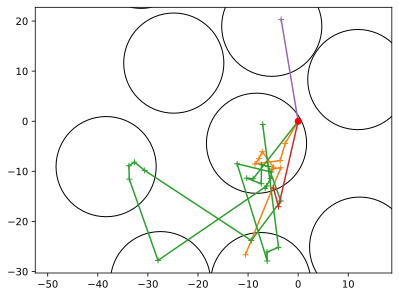

In [10]:
%matplotlib inline 
from RATlibUtils.plotters import plotter6
# these are the data files
# interactions
file=BPMS+"/obj/RATstart.ray.dat"
# object locations
file1=BPMS+"/obj/RATstart.obj.dat"
plotter6(file,file1)

In [11]:
%%bash
# tidy up the files we created

source examples_init.sh
BPMSROOT=$BPMS/obj
rm -f $BPMSROOT/RATstart.obj.dat \
      $BPMSROOT/RATstart.out.dat \
      $BPMSROOT/RATstart.ray.dat

### Option 7: query materials

    7                   : get and print materials

In [12]:
%%bash
source examples_init.sh

# Query materials
# option 7
RATstart $BPMSROOT/first.obj <<< 7

There are 4 materials:

***** Material 0 *****
	name: WHITE	is used? 0
	type: (0) = srm with reflectance
	Number in used material list = -1 
	nBands: 2:
0.000000 1.000000 
100000000000000000000.000000 1.000000 
***** Material 1 *****
	name: TRANSPARENT	is used? 0
	type: (10) = transparent
	Number in used material list = -1 
***** Material 2 *****
	name: green	is used? 1
	type: (0) = srm with reflectance
	Number in used material list = 0 	name: green
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 
***** Material 3 *****
	name: white	is used? 1
	type: (0) = srm with reflectance
	Number in used material list = 1 	name: white
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 


### Option 9: print info on materials used

        9                   : print info on materials used

In [13]:
%%bash
source examples_init.sh
# option 9
RATstart $BPMSROOT/first.obj <<< 9

There are 4 materials defined
There are 2 materials used:

***** Material 0 *****
	name: green	index: 2
	type: (0) = srm with reflectance
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 
***** Material 1 *****
	name: white	index: 3
	type: (0) = srm with reflectance
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 


### Option 10: get and set verbosity level (0-1)

    10                  : get and set verbosity level (0-1)

In [14]:
%%bash
source examples_init.sh

# interactions to set verbosity to 1
RATstart first.obj << EOF 
10
y
1
EOF

Verbose level is currently 0
	Change it? (y/n): 
set verbosity level (0-1): Verbose level is now 1


In [15]:
%%bash
source examples_init.sh

# interactions to set verbosity to 0
RATstart first.obj << EOF 
10
y
0
EOF

Verbose level is currently 0
	Change it? (y/n): 
set verbosity level (0-1): Verbose level is now 0


But normally, we would just use the command line to set this:



In [16]:
%%bash
source examples_init.sh

# interactions to set verbosity to 1
RATstart -RATv 1 first.obj << EOF 
0
EOF

testing object file for material library first.obj
testing material library plants.matlib.new
Found up to 4 materials in /Users/plewis/Documents/GitHub/librat/obj/first.obj and preceding files
RATstart:
	VERBOSE flag on (-v option)
{GLOBAL
	(default) diffuse (reflectance) material	WHITE...

	(default) transparent material	TRANSPARENT...
reading material library plants.matlib.new

	diffuse material	green...
3 lines   read in file /Users/plewis/Documents/GitHub/librat/obj/green.dat
2 columns read in file /Users/plewis/Documents/GitHub/librat/obj/green.dat

			...read
	diffuse material	white...
3 lines   read in file /Users/plewis/Documents/GitHub/librat/obj/white.dat
2 columns read in file /Users/plewis/Documents/GitHub/librat/obj/white.dat

			...read
<green>PLANE{0<white>{1s[BBox: (-1.00,-1.00,-1.00) (1.00,1.00,1.00)]1}[BBox: (-1.00,-1.00,-1.00) (1.00,1.00,1.00)]0}

In [17]:
%%bash
source examples_init.sh

# interactions to set verbosity to 0
RATstart -RATv 0 first.obj << EOF 
0
EOF

RATstart:
	VERBOSE flag on (-v option)


### Option 11: get and print object bbox information

    11                  : get and print object bbox information

In [18]:
%%bash
source examples_init.sh

# interactions to set verbosity to 1
RATstart first.obj <<< 11 


x: -0.999800 1.000200
y: -0.999800 1.000200
z: -0.999800 1.000200
bbox centre @ 0.000200 0.000200 0.000200


### Option 16: produce a height map 

    16 cx cy cz sx sy nrows ncols rpp name : produce a height map in name
    
Recall that `first.obj` is a plane at `z=0` and a sphere or radius 1 centred at `(0, 0, 0)`. Option `16` produces an image dataset (in a rather old 'hips' format) that is a height map of the scene, produced by ray casting. Imagine a rectangle on an `x-y` plane of physical dimensions `(sx, sy)`, centred at `(cx, cy, cz)`. This option samples such a plane, with `(nrows, ncols)` dimensions, with `rpp` samples per output pixel. The result is written to the image defined by `name`.

A simple use of this option, illustrated below, is to give a scene height map. In this case, we want `(cx, cy, cz)` to be above the `z-dimension` of the scene bounding box. Lets first re-familase ourselves with the object file, and look at its bounding box (option `11`):


In [19]:
%%bash
source examples_init.sh

# lets look at it
cat $BPMS/obj/first.obj
echo "11" | RATstart first.obj


# My first object file
mtllib plants.matlib.new
usemtl green 
v 0 0 0 
v 0 0 1 
plane -1 -2 
!{
usemtl white 
!{ 
v 0 0 0 
sph -1 1
!} 
!}
x: -0.999800 1.000200
y: -0.999800 1.000200
z: -0.999800 1.000200
bbox centre @ 0.000200 0.000200 0.000200


The maximum `z` is given as `1.000200` (some tolerance is added in calculating the bounding box extent, as really it is `1.000000`). We therefore centre our simulation at `(0, 0, 2)`. We set the scene `x` and `y` dimensions to 4 units, and produce an image of 200 by 200 pixels with 1 ray per pixel.

In [20]:
%%bash
source examples_init.sh

# output image name
op=$BPMS/obj/out1.hips

echo "16 0 0 2 4 4  200 200 1 $op" | RATstart \
    -RATsensor_wavebands wavebands.dat  \
    -RATv first.obj

RATstart:
	VERBOSE flag on (-v option)
read_spectral_file:	3 data entries read in file /Users/plewis/Documents/GitHub/librat/obj/wavebands.dat
( 99.9975)              

We use the python library `libhipl` (locally installed) to read the image, then display it using matplotlib:

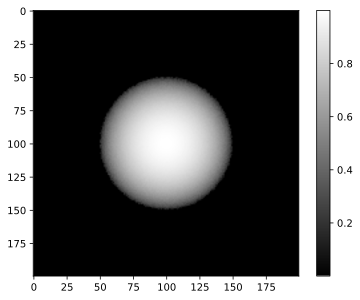

In [21]:
from RATlibUtils.libhipl import Hipl
import pylab as plt

f = BPMS+'/obj/out1.hips'
rabbit=Hipl().read(f)
plt.imshow(rabbit,cmap='gray')
plt.colorbar()

In [22]:
%%bash
source examples_init.sh

# output image name
op=$BPMS/obj/out2.hips

RATstart HET01_DIS_ERE.obj <<EOF
11
16 0 0 30 200 200  200 200 1 $op
EOF


x: -55.000000 55.000000
y: -55.000000 55.000000
z: 0.000000 27.603159
bbox centre @ 0.000000 0.000000 13.801580


( 99.9975)              

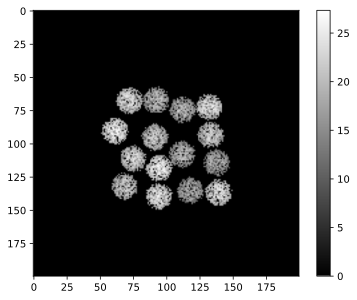

In [23]:
from RATlibUtils.libhipl import Hipl
import pylab as plt

f = BPMS+'/obj/out2.hips'
rabbit=Hipl().read(f)
plt.imshow(rabbit,cmap='gray')
plt.colorbar()

## Summary

In this section, we have explored the input options for `librat`. These consist of a numeric code on on command line input, followed by some (possibly interactive) set of parameters. We have explored all of those listed, other than `13` and `14` which refer to camera and light files.